# Simulation Wrapper

5/27/21

#### Summary:
Run a crude version of system realization and latency measurements given the offloading decisions are identical for user to assumptions in container dispatchment.
- Initialize the system (servers, users, containers)
- Deploy the containers for one cycle
- Offload user jobs and record lateny throughout the system 
- Move the users based on their markovian mobility
- Reassign containers and repeat

In [1]:
cd /home/tkim/Academics/DistMEC

/home/tkim/Academics/DistMEC


### Import Relevant Libraries and Dependencies

In [2]:
import numpy as np
import math
import copy

from classes.Application import *
from classes.User import *
from classes.Server import *
from solver.Sim_Params import *
from classes.Central_Controller import *
from classes.Container import *

### Build Wrapper Class

The wrapper class should propagate between small and big timesteps.

Functions should take charge of each step of the cycle

In [26]:
class Sim_Params:
    """
    Simulation params hold information about system setting for simulation
    - timestep - 5 min per timestep
    - length - 1 mile per unit length
    """
    
    def __init__(self, big_ts, small_ts, x_length, y_length, num_users, num_servers, num_apps, cc_mode = 'dist',
                 app_mode = 'dist'):
        
        self.big_ts = big_ts
        self.small_ts = small_ts
        self.x_length = x_length
        self.y_length = y_length
        self.num_users = num_users
        self.num_servers = num_servers
        self.num_apps = num_apps
        self.cc_mode = cc_mode
        self.app_mode = app_mode
        
        # Non-specified instances
        self.low_mean_jobs = 5
        self.high_mean_jobs = 15
        self.server_weak_range = np.array([[2,2]])
        self.server_strong_range = np.array([[2,2]])
        self.user_max_speed = 2.5
        self.user_lamdas = [1/0.7,1/2,1/0.7] # 3 mph, 10 mph, 20 mph
        self.user_num_path = 10
        self.container_service_low = 20
        self.container_service_high = 30
        self.deploy_rounds = 5
        self.dist_n = 1

In [27]:
def setup_sim(sim_param):
    
    # Create Job Profiles
    num_app_types = sim_param.num_apps
    low_mean = sim_param.low_mean_jobs
    high_mean = sim_param.high_mean_jobs
    job_profiles = []

    for i in range(num_app_types):
        job_profiles += [Job_Profile(job_name = str(i),
                                     latency_req = 3,
                                     offload_mean = np.random.uniform(low_mean,high_mean))]


    # System physical Boundaries - All action takes within this
    boundaries = np.array([[0,sim_param.x_length],[0,sim_param.y_length]])


    # Generate Servers
    num_resource = 1
    weak_range = sim_param.server_weak_range
    strong_range = sim_param.server_strong_range

    # Generate Server
    servers = []
    idx_counter = 0

    for i in range(sim_param.num_servers):
        servers.append(Server(boundaries,level=2,rand_locs=True,locs=None))
        servers[-1].server_resources(num_resource, weak_range, strong_range)
        servers[-1].assign_id(idx_counter)
        idx_counter += 1


    # Generate Users
    users= []
    idx_counter = 0


    for i in range(sim_param.num_users):
        users += [User(boundaries, sim_param.big_ts, 2, sim_param.user_lamdas, sim_param.user_max_speed)]
        users[-1].generate_MC(servers)
        users[-1].assign_id(idx_counter)
        idx_counter += 1


    # Generate Apps
    num_apps = len(users)
    app_id = np.random.choice(num_app_types,num_apps)
    apps = []

    for i in range(len(app_id)):
        apps += [Application(job_type=app_id[i], user_id=i, 
                             time_steps=sim_param.big_ts, job_profiles=job_profiles, mode = sim_param.app_mode,
                             dist_n = sim_param.dist_n, user = users[i])]
        
    # Generate Containers - in dictionary indexed by {(server,app)}
    containers = {}
    
    for s in range(len(servers)):
        for a in range(num_app_types):
            service_rate = np.random.uniform(sim_param.container_service_low, sim_param.container_service_high)
            latency_restriction = job_profiles[a].latency_req
            containers[(s,a)] = Container(a, s, service_rate, latency_restriction)

    return servers, users, containers, apps

### Run the system

First set up simulation parameters and generate players (servers, users, containers, apps)

In [28]:
sim_param = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3)
servers, users, containers, apps = setup_sim(sim_param)

Initially run the scenario of job arrivals and process during small TS.

In [29]:
def run_sim_temp(sim_param, servers, users, containers, apps):

    # Loop through big time step
    cc = Central_Controller(servers, containers, sim_param, apps, users)
    cc.mode = sim_param.cc_mode
    cc_deployment_history = {}

    for bt in range(sim_param.big_ts):

        # Deploy the containers to the servers
        cc.big_ts = bt
        cc.VM_placement(users,apps,sim_param.deploy_rounds)
        cc_deployment_history[bt] = cc.container_deployed

        # For each small time step offload and serve at container
        for st in range(sim_param.small_ts):
            # random order between users when offloading for each app
            cc.small_ts = st
            usr_order = np.arange(len(users))
            np.random.shuffle(usr_order)

            temp_containers = {}
            queue_replies = {}

            # Make offloading decision
            for u in usr_order:
                # Generate load
                apps[u].new_load(ts_big=bt,ts_small=st)
                # Decide to offload given servers --> add offload policy to app class
                offload_u = apps[u].offload(cc.container_deployed, bt, st, cc)
                for (s,a) in offload_u.keys():
                    if (s,a) not in temp_containers:
                        temp_containers[(s,a)] = np.empty([0,4])
                    temp_containers[(s,a)] = np.append(temp_containers[(s,a)],offload_u[(s,a)],axis=0)

            # Scramble arrived job and add to queue, apps record latency
            for (s,a) in temp_containers.keys():
                sa_offload = temp_containers[(s,a)]
                np.random.shuffle(sa_offload) 
                replies = containers[(s,a)].add_to_queue(sa_offload)
                # print(containers[(s,a)].queue)
                queue_replies[(s,a)] = replies

                for i in range(replies.shape[0]):
                    # Add distance between app and server
                    a_id, reply_len, load = int(replies[i,0]), replies[i,2], replies[i,1]
                    dist = cc.server_dists[int(users[a_id].user_voronoi_true[bt]),s]
                    apps[a_id].record_queue_length(reply_len, s, bt, st, load, dist)

                # Service the queue
                containers[(s,a)].serve_ts()

    return apps

### Record Costs

Compare costs given 4 different scenarios. We will analyze the cost of queue latency, and distance latency separately.

The conditions are as follows:

- VM Placement scheme - uniform/distance (n=2)
- Offloading - uniform/distance (n=2)

In [30]:
num_trial = 10

q_01, l_01 = 0,0
q_02, l_02 = 0,0
q_03, l_03 = 0,0
q_04, l_04 = 0,0

sp_temp = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                      cc_mode = 'dist', app_mode = 'dist')

for t in range(num_trial):
    print(t)

    servers, users, containers, apps = setup_sim(sp_temp)
    
    # Run each simulation with edited values
    sim_param_01 = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                      cc_mode = 'uni', app_mode = 'uni')
    
    apps1 = copy.deepcopy(apps)
    for a in apps1:
        a.mode = sim_param_01.app_mode
    apps_01 = run_sim_temp(sim_param_01, servers, users, containers, apps1)
    
    
    
    # Scenario 2 - VM - uniform, App - dist
    sim_param_02 = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                          cc_mode = 'uniform', app_mode = 'dist')
    
    apps2 = copy.deepcopy(apps)    
    for a in apps2:
        a.mode = sim_param_02.app_mode
    apps_02 = run_sim_temp(sim_param_02,servers, users, containers, apps2)

    
    
    # Scenario 3 - VM - dist, App - uniform
    sim_param_03 = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                          cc_mode = 'dist', app_mode = 'uniform')
    
    
    apps3 = copy.deepcopy(apps)
    for a in apps3:
        a.mode = sim_param_03.app_mode
    apps_03 = run_sim_temp(sim_param_03,servers, users, containers, apps3)
    
    # Scenario 4 - dist, dist
    sim_param_04 = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                          cc_mode = 'dist', app_mode = 'dist')
    apps4 = copy.deepcopy(apps)
    for a in apps4:
        a.mode = sim_param_04.app_mode
    apps_04 = run_sim_temp(sim_param_04, servers, users, containers, apps4)

    for u in range(len(apps_01)):
        for key in apps_01[u].queue_length.keys():
            q_01 += np.sum(apps_01[u].queue_length[key][:,3] * apps_01[u].queue_length[key][:,2])
            l_01 += np.sum(apps_01[u].queue_length[key][:,4] * apps_01[u].queue_length[key][:,2])

        for key in apps_02[u].queue_length.keys():
            q_02 += np.sum(apps_02[u].queue_length[key][:,3]* apps_02[u].queue_length[key][:,2])
            l_02 += np.sum(apps_02[u].queue_length[key][:,4]* apps_02[u].queue_length[key][:,2])

        for key in apps_03[u].queue_length.keys():
            q_03 += np.sum(apps_03[u].queue_length[key][:,3]* apps_03[u].queue_length[key][:,2])
            l_03 += np.sum(apps_03[u].queue_length[key][:,4]* apps_03[u].queue_length[key][:,2])

        for key in apps_04[u].queue_length.keys():
            q_04 += np.sum(apps_04[u].queue_length[key][:,3]* apps_04[u].queue_length[key][:,2])
            l_04 += np.sum(apps_04[u].queue_length[key][:,4]* apps_04[u].queue_length[key][:,2])

0
1
2
3
4
5
6
7
8
9


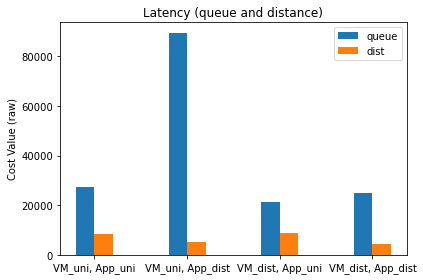

In [31]:
import matplotlib.pyplot as plt

labels = ['VM_uni, App_uni','VM_uni, App_dist', 'VM_dist, App_uni', 'VM_dist, App_dist']
q_vals = np.array([q_01/num_trial, q_02/num_trial, q_03/num_trial, q_04/num_trial])
l_vals = np.array([l_01/num_trial, l_02/num_trial, l_03/num_trial, l_04/num_trial])
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
x = np.arange(len(labels))
rects1 = ax.bar(x - width/2, q_vals, width, label='queue')
rects2 = ax.bar(x + width/2, l_vals, width, label='dist')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cost Value (raw)')
ax.set_title('Latency (queue and distance)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


### Run with different dist_n values 

Show that different offload amounts may lead to different performances.

In [12]:
num_trial = 10

q_01, l_01 = 0,0
q_02, l_02 = 0,0
q_03, l_03 = 0,0
q_04, l_04 = 0,0

sp_temp = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                      cc_mode = 'dist', app_mode = 'dist')

for t in range(num_trial):
    print(t)

    servers, users, containers, apps = setup_sim(sp_temp)
    
    # Run each simulation with edited values
    sim_param_01 = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                      cc_mode = 'dist', app_mode = 'dist')
    sim_param_01.dist_n = 1
    
    apps1 = copy.deepcopy(apps)
    for a in apps1:
        a.dist_n = sim_param_01.dist_n
        
    apps_01 = run_sim_temp(sim_param_01, servers, users, containers, apps1)
    
    
    
    # Scenario 2 - VM - uniform, App - dist
    sim_param_02 = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                          cc_mode = 'uniform', app_mode = 'dist')
    sim_param_02.dist_n = 0.1
    
    apps2 = copy.deepcopy(apps)    
    for a in apps2:
        a.dist_n = sim_param_02.dist_n
    apps_02 = run_sim_temp(sim_param_02,servers, users, containers, apps2)

    
    
    # Scenario 3 - VM - dist, App - uniform
    sim_param_03 = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                          cc_mode = 'dist', app_mode = 'uniform')
    sim_param_03.dist_n = 0.01
    
    apps3 = copy.deepcopy(apps)
    for a in apps3:
        a.dist_n = sim_param_03.dist_n
    apps_03 = run_sim_temp(sim_param_03,servers, users, containers, apps3)
    
    # Scenario 4 - dist, dist
    sim_param_04 = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=15, num_servers=10, num_apps=3,
                          cc_mode = 'dist', app_mode = 'dist')
    sim_param_04.dist_n = 0.001
    
    apps4 = copy.deepcopy(apps)
    for a in apps4:
        a.dist_n = sim_param_04.dist_n
    apps_04 = run_sim_temp(sim_param_04, servers, users, containers, apps4)

    for u in range(len(apps_01)):
        for key in apps_01[u].queue_length.keys():
            q_01 += np.sum(apps_01[u].queue_length[key][:,3] * apps_01[u].queue_length[key][:,2])
            l_01 += np.sum(apps_01[u].queue_length[key][:,4] * apps_01[u].queue_length[key][:,2])

        for key in apps_02[u].queue_length.keys():
            q_02 += np.sum(apps_02[u].queue_length[key][:,3]* apps_02[u].queue_length[key][:,2])
            l_02 += np.sum(apps_02[u].queue_length[key][:,4]* apps_02[u].queue_length[key][:,2])

        for key in apps_03[u].queue_length.keys():
            q_03 += np.sum(apps_03[u].queue_length[key][:,3]* apps_03[u].queue_length[key][:,2])
            l_03 += np.sum(apps_03[u].queue_length[key][:,4]* apps_03[u].queue_length[key][:,2])

        for key in apps_04[u].queue_length.keys():
            q_04 += np.sum(apps_04[u].queue_length[key][:,3]* apps_04[u].queue_length[key][:,2])
            l_04 += np.sum(apps_04[u].queue_length[key][:,4]* apps_04[u].queue_length[key][:,2])

0
1
2
3
4
5
6
7
8
9


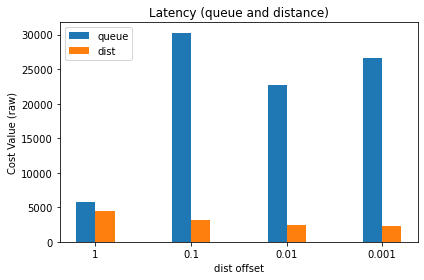

In [13]:
import matplotlib.pyplot as plt

labels = ['1','0.1', '0.01', '0.001']
q_vals = np.array([q_01/num_trial, q_02/num_trial, q_03/num_trial, q_04/num_trial])
l_vals = np.array([l_01/num_trial, l_02/num_trial, l_03/num_trial, l_04/num_trial])
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
x = np.arange(len(labels))
rects1 = ax.bar(x - width/2, q_vals, width, label='queue')
rects2 = ax.bar(x + width/2, l_vals, width, label='dist')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cost Value (raw)')
ax.set_xlabel('dist offset')
ax.set_title('Latency (queue and distance)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()
